In [1]:
import keras
import csv
import os
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet import MobileNet
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
TRAIN_DIR = os.path.join(ROOT_DIR, 'data', 'train')
TEST_DIR =  os.path.join(ROOT_DIR, 'data', 'validation')

In [4]:
img_width, img_height = 300, 300

In [5]:
batch_size = 64
epoch = 10
drop_prob = 0.7
out_class = 13

In [6]:
train_gen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.2, horizontal_flip = True, vertical_flip = True)

In [7]:
test_gen = ImageDataGenerator(rescale=1. / 255)

In [8]:
train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 152397 images belonging to 13 classes.


In [9]:
'''val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')'''

"val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), \n                                                batch_size=batch_size, class_mode='categorical')"

In [10]:
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 55388 images belonging to 13 classes.


In [11]:
input_ = Input(shape=(img_width, img_height, 3))

transfer_model = MobileNet(input_tensor = input_, weights = 'imagenet', include_top = False)

/home/aumkar/anaconda3/envs/daenv/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step


In [12]:
x = transfer_model.output

x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)

x = Dropout(drop_prob)(x)

out = Dense(out_class, activation = 'softmax')(x)

In [13]:
model = Model(inputs = transfer_model.input, outputs = out)

In [14]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [15]:
for layer in transfer_model.layers:
    layer.trainable = False

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 301, 301, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 150, 150, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 150, 150, 32)      128       
__________

In [ ]:
#tensorboard = TensorBoardColabCallback(TensorBoardColab()) #Using Tensorboard on google colab

In [ ]:
checkpointer = ModelCheckpoint(filepath='checkpoint_inception.h5', save_best_only=True)

In [ ]:
callback_list = [checkpointer]

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch = int(152397/batch_size), epochs = epoch, shuffle = True)

Epoch 1/10
2381/2381 [==============================] - 1984s 833ms/step - loss: 1.5510 - acc: 0.7779
Epoch 2/10
2381/2381 [==============================] - 1973s 829ms/step - loss: 0.7172 - acc: 0.8853
Epoch 3/10
2381/2381 [==============================] - 2023s 850ms/step - loss: 0.5856 - acc: 0.9027
Epoch 4/10
2381/2381 [==============================] - 2020s 848ms/step - loss: 0.5274 - acc: 0.9122
Epoch 5/10
2381/2381 [==============================] - 2016s 847ms/step - loss: 0.4949 - acc: 0.9171
Epoch 6/10
2381/2381 [==============================] - 2003s 841ms/step - loss: 0.4898 - acc: 0.9189
Epoch 7/10
2381/2381 [==============================] - 1991s 836ms/step - loss: 0.4791 - acc: 0.9206
Epoch 8/10
2381/2381 [==============================] - 1988s 835ms/step - loss: 0.4653 - acc: 0.9218
Epoch 9/10
2381/2381 [==============================] - 1984s 833ms/step - loss: 0.4673 - acc: 0.9229
Epoch 10/10
2381/2381 [==============================] - 1979s 831ms/step - loss: 

In [19]:
Y_pred = model.predict_generator(test_generator, int(55388/batch_size+1))
y_pred = np.argmax(Y_pred, axis=1)

In [20]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, int(55388/batch_size+1))

In [21]:
test_loss

6.169823721168514

In [27]:
test_accuracy

0.41844803929079255

In [ ]:
model_check = load_model('checkpoint_inception.h5')

In [ ]:
#test_check_loss, test_check_acc = model_check.evaluate_generator(test_generator, int(795/batch_size+1))

In [ ]:
test_check_loss

In [ ]:
test_check_acc

In [22]:
target_names = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 
                'skateboard', 'train', 'truck']

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

In [24]:
cnf = confusion_matrix(test_generator.classes, y_pred)

Confusion matrix
[[ 512   89  834  232  184  100  676   42   91  133  519  234]
 [ 481   78  816  221  156   82  675   30   94  131  504  207]
 [ 606  121 1098  325  201  133  889   33   99  189  723  273]
 [1505  219 2382  667  527  286 2015   78  265  398 1455  604]
 [ 647  119  996  306  229  126  962   47  113  164  711  271]
 [ 297   55  468  132  104   52  419   13   55   83  278  119]
 [ 780  126 1318  409  267  164 1072   51  153  198  847  411]
 [ 586  100  920  242  167  105  757   24  103  152  593  251]
 [ 602  114 1054  273  198  131  911   41  117  147  660  301]
 [ 341   52  482  130  100   56  459   17   72  107  326  139]
 [ 591  102  966  287  202  108  782   41  128  146  619  264]
 [ 789  128 1241  330  251  164 1041   51  149  217  792  395]]


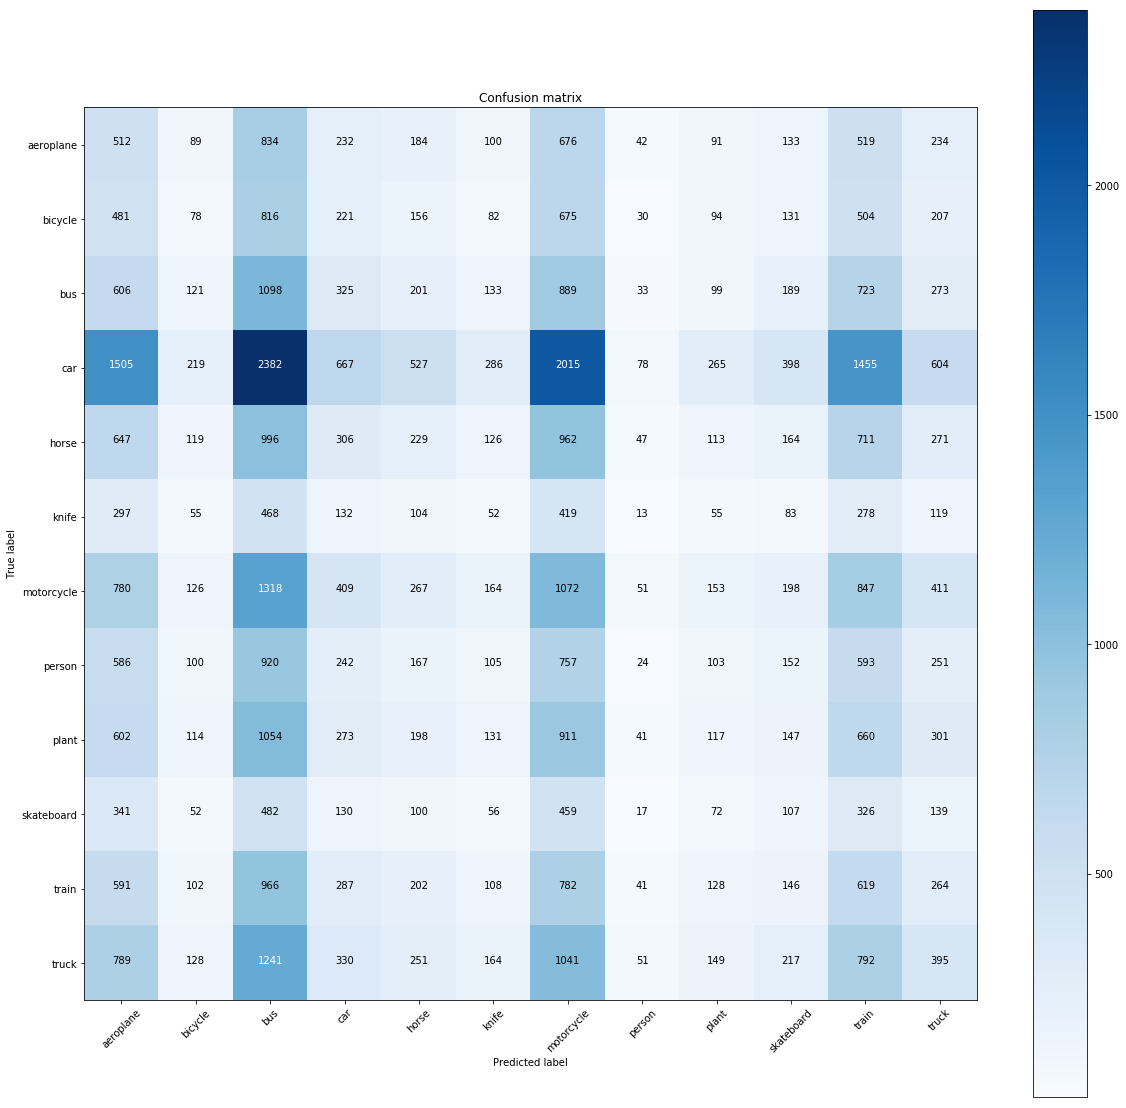

In [25]:
plot_confusion_matrix(cnf, classes=target_names, title='Confusion matrix')

In [26]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   aeroplane       0.07      0.14      0.09      3646
     bicycle       0.06      0.02      0.03      3475
         bus       0.09      0.23      0.13      4690
         car       0.19      0.06      0.10     10401
       horse       0.09      0.05      0.06      4691
       knife       0.03      0.03      0.03      2075
  motorcycle       0.10      0.18      0.13      5796
      person       0.05      0.01      0.01      4000
       plant       0.08      0.03      0.04      4549
  skateboard       0.05      0.05      0.05      2281
       train       0.08      0.15      0.10      4236
       truck       0.11      0.07      0.09      5548

   micro avg       0.09      0.09      0.09     55388
   macro avg       0.08      0.08      0.07     55388
weighted avg       0.10      0.09      0.08     55388



In [28]:
model.save('mobilenet.h5')